In [1]:
!pwd

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))# デフォルトは75%

import sys
sys.executable

/c/Users/shingo/jupyter_notebook/tfgpu_py36_work/02_keras_py/experiment


'C:\\Users\\shingo\\Anaconda3\\envs\\tfgpu20\\python.exe'

# multiclass model

#### 犬猫画像は以下のサイトから取得できた
- https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765


#### import

In [2]:
# モジュールimport
import os, sys
sys.path.append(r'C:\Users\shingo\jupyter_notebook\tfgpu_py36_work\02_keras_py')
from dataset import plot_log, util
from model import tf_define_model as define_model
from model import tf_my_callback as my_callback
from model import tf_lr_finder as lr_finder
from transformer import tf_my_generator as my_generator
from transformer import tf_get_train_valid_test as get_train_valid_test
from predicter import tf_grad_cam as grad_cam
from predicter import tf_base_predict as base_predict
from predicter import roc_curve, conf_matrix, ensemble_predict

from tensorflow import keras
keras.backend.clear_session()

import glob, time, pathlib
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%reload_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))# 75%

#### parameters

In [12]:
# 出力ディレクトリ
output_dir = r'D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test'
os.makedirs(output_dir, exist_ok=True)

# 入力ディレクトリ
train_data_dir = r'D:\work\kaggle_data\Cats_VS._Dogs\images\small_set\train'
train_samples = len(util.find_img_files(train_data_dir))

validation_data_dir = r'D:\work\kaggle_data\Cats_VS._Dogs\images\small_set\validation'
val_samples = len(util.find_img_files(validation_data_dir))

test_dir = r'D:\work\kaggle_data\Cats_VS._Dogs\images\small_set\test'
test_samples = len(util.find_img_files(test_dir))

gpu_num = 0# "0,1,2,3"

# 分類クラス
class_name = sorted([str(pathlib.Path(dir_name).name) for dir_name in glob.glob(train_data_dir+'/*')])#['Cat', 'Dog']
classes = class_name
nb_classes = len(classes)

# エポック数、バッチサイズ
num_epoch = 2
batch_size = 50
val_batch_size = 50
test_batch_size = 50

# 入力層のサイズ
img_rows, img_cols, channels = 100, 100, 3

# finetuning model
choice_model = 'VGG16'#'EfficientNet'#'InceptionV3'
trainable = 15#249#'all'
is_skip_bn = True
model_path = None

# 全結合層
fcs = [256]
drop = 0.5
is_add_batchnorm = True#False
l2_rate = 1e-4

# optimizer
choice_optim='sgd'
lr = 0.1 * batch_size / 128
lr_factor = 0.01
    
# data augmentation
rescale = 1.0/255.0
#width_shift_range = 0.2
#height_shift_range = 0.2
#horizontal_flip = True
#vertical_flip = True
#shear_range = 20
#zoom_range_min = 0.8
#zoom_range_max = 1.2
#rotation_range = 20
#channel_shift_range = 5.
#brightness_range_min = 0.3
#brightness_range_max = 1.0
#mix_up_alpha = 0.2# mixup alpha
#random_crop = [224,224]# random_crop size
random_erasing_prob = 0.5 # random_erasing 確率
#random_erasing_maxpixel = 255
ricap_beta = 0.3 # RICAP beta
ricap_use_same_random_value_on_batch = True # Trueとすれば論文と同じように「ミニバッチ間で共通の乱数を使う例」。Falseにすれば、「サンプル間で別々の乱数を使う例」
#is_kuzushiji_gen = True # 下山さんが使っていたAutoAugmentのデフォルト？変換入れるか
randaugment_N, randaugment_M = 3, 4 # Rand_Augment

In [13]:
# my_IDG_optionsに値詰める。papermillで実行した時でもうまくいくようにする

gpus = str(gpu_num)

if 'zoom_range_min' in list(locals().keys()) and 'zoom_range_max' in list(locals().keys()):
    zoom_range = [zoom_range_min, zoom_range_max]
    
if 'brightness_range_min' in list(locals().keys()) and 'brightness_range_max' in list(locals().keys()):
    brightness_range = [brightness_range_min, brightness_range_max]

my_IDG_options = {}
if 'rescale' in list(locals().keys()):
    my_IDG_options['rescale'] = rescale
        
if 'width_shift_range' in list(locals().keys()):
    my_IDG_options['width_shift_range'] = width_shift_range
    
if 'height_shift_range' in list(locals().keys()):
    my_IDG_options['height_shift_range'] = height_shift_range
    
if 'horizontal_flip' in list(locals().keys()):
    my_IDG_options['horizontal_flip'] = horizontal_flip
    
if 'vertical_flip' in list(locals().keys()):
    my_IDG_options['vertical_flip'] = vertical_flip
    
if 'shear_range' in list(locals().keys()):
    my_IDG_options['shear_range'] = shear_range
    
if 'zoom_range' in list(locals().keys()):
    my_IDG_options['zoom_range'] = zoom_range
    
if 'rotation_range' in list(locals().keys()):
    my_IDG_options['rotation_range'] = rotation_range

if 'channel_shift_range' in list(locals().keys()):
    my_IDG_options['channel_shift_range'] = channel_shift_range

if 'brightness_range' in list(locals().keys()):
    my_IDG_options['brightness_range'] = brightness_range    

if 'mix_up_alpha' in list(locals().keys()):
    my_IDG_options['mix_up_alpha'] = mix_up_alpha
    
if 'random_erasing_prob' in list(locals().keys()):
    my_IDG_options['random_erasing_prob'] = random_erasing_prob
    
if 'random_erasing_maxpixel' in list(locals().keys()):
    my_IDG_options['random_erasing_maxpixel'] = random_erasing_maxpixel

if 'ricap_beta' in list(locals().keys()):
    my_IDG_options['ricap_beta'] = ricap_beta
    
if 'ricap_use_same_random_value_on_batch' in list(locals().keys()):
    my_IDG_options['ricap_use_same_random_value_on_batch'] = ricap_use_same_random_value_on_batch
    
if 'is_kuzushiji_gen' in list(locals().keys()):
    my_IDG_options['is_kuzushiji_gen'] = is_kuzushiji_gen
    
if 'randaugment_N' in list(locals().keys()):
    my_IDG_options['randaugment_N'] = randaugment_N
    
if 'randaugment_M' in list(locals().keys()):
    my_IDG_options['randaugment_M'] = randaugment_M

#### data generator

In [14]:
def check_gen(gen):
    """ generatorの画像確認 """
    from PIL import Image
    import matplotlib.pyplot as plt
    import numpy as np
    %matplotlib inline
    x,y = next(gen)
    if isinstance(y, list):
        y = np.array(y)
    print(f"x.shape: {x.shape}")
    print(f"y.shape: {y.shape}")
    #print(f"y:\n{y}")
    print(f"y[0]: {y[0]}")
    util.plot_5imgs(x)
    return x,y

In [15]:
d_cls = get_train_valid_test.LabeledDataset([img_rows, img_cols, channels]
                                            , batch_size, valid_batch_size=val_batch_size, test_batch_size=test_batch_size
                                            , train_samples=train_samples, valid_samples=val_samples, test_samples=test_samples)

d_cls.create_my_generator_flow_from_directory(train_data_dir
                                              , classes
                                              , valid_data_dir=validation_data_dir
                                              , test_data_dir=test_dir
                                              , color_mode='rgb'
                                              , class_mode='categorical'
                                              , my_IDG_options=my_IDG_options
                                              , is_valid_grayscale=False # validation generatorをグレースケール化するか
                                             )

train_steps_per_epoch : 20
valid_steps_per_epoch : 8
test_steps_per_epoch : 1
my_IDG_options: {'rescale': 0.00392156862745098, 'random_erasing_prob': 0.5, 'ricap_beta': 0.3, 'ricap_use_same_random_value_on_batch': True, 'randaugment_N': 3, 'randaugment_M': 4}
Found 400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


(<generator object MyImageDataGenerator.flow_from_directory at 0x00000216076F3148>,
 <keras_preprocessing.image.directory_iterator.DirectoryIterator at 0x216076e5908>)

Found 1000 images belonging to 2 classes.
x.shape: (50, 100, 100, 3)
y.shape: (50, 2)
y[0]: [0.95 0.05]
Num_Images:  50


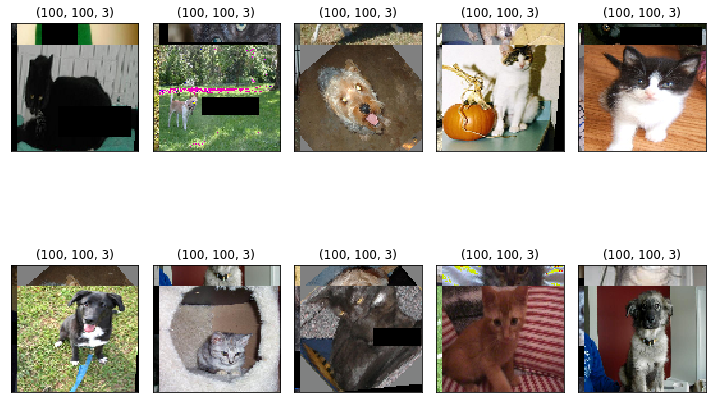

<Figure size 432x288 with 0 Axes>

In [16]:
x,y = check_gen(d_cls.train_gen)

x.shape: (50, 100, 100, 3)
y.shape: (50, 2)
y[0]: [1. 0.]
Num_Images:  50


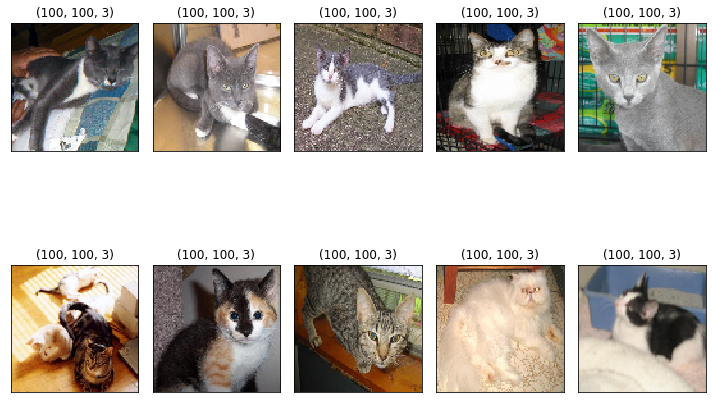

<Figure size 432x288 with 0 Axes>

In [17]:
x,y = check_gen(d_cls.valid_gen)

x.shape: (50, 100, 100, 3)
y.shape: (50, 2)
y[0]: [1. 0.]
Num_Images:  50


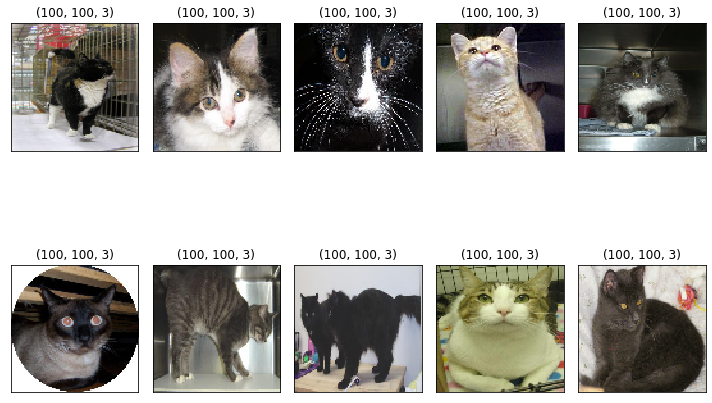

<Figure size 432x288 with 0 Axes>

In [18]:
x,y = check_gen(d_cls.test_gen)

#### model

In [19]:
# loss
loss = 'categorical_crossentropy'
metrics = ['accuracy']
activation = 'softmax'

# model
if model_path is None:
    if trainable != 'all':
        trainable = int(trainable)
    model, orig_model = define_model.get_fine_tuning_model(output_dir, img_rows, img_cols, channels
                                                           , len(classes)
                                                           , choice_model, trainable
                                                           , fcs=fcs, drop=drop
                                                           , is_add_batchnorm=is_add_batchnorm
                                                           , l2_rate=l2_rate
                                                           , activation=activation
                                                           , gpu_count=len(gpus.split(','))
                                                           , skip_bn=is_skip_bn
                                                          )
else:
    model = keras.models.load_model(model_path, compile=False)
    
optim = define_model.get_optimizers(choice_optim, lr=lr)
model.compile(loss=loss, optimizer=optim, metrics=metrics)

----- model_param -----
output_dir = D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test
img_rows img_cols channels = 100 100 3
num_classes = 2
choice_model trainable = VGG16 15
fcs = [256]
fcpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = softmax
gpu_count = 1
skip_bn = True
n_multitask = 1
----- FC_layers -----
dence dropout is_add_batchnorm kernel_initializer l2_rate = 256 0.5 True he_normal 0.0001
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.0390625 0.9 0.0 True


In [20]:
define_model.print_model_summary(model)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

In [21]:
# 最適な学習率探索. 後続処理実行する場合はデータとモデル再定義必要
#lr_finder.run(model, d_cls.train_gen, batch_size, d_cls.init_train_steps_per_epoch, output_dir=output_dir)

#### train

Epoch 1/2
19/20 [===========================>..] - ETA: 0s - loss: 0.7370 - accuracy: 0.5979
Epoch 00001: val_loss improved from inf to 1.81213, saving model to D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test\val_loss_best.h5

Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test\val_accuracy_best.h5
20/20 [==============================] - 9s 426ms/step - loss: 0.7357 - accuracy: 0.6010 - val_loss: 1.8121 - val_accuracy: 0.5000
Epoch 2/2
19/20 [===========================>..] - ETA: 0s - loss: 1.0689 - accuracy: 0.5653
Epoch 00002: val_loss did not improve from 1.81213

Epoch 00002: val_accuracy did not improve from 0.50000
20/20 [==============================] - 5s 248ms/step - loss: 1.0700 - accuracy: 0.5720 - val_loss: 7.9813 - val_accuracy: 0.5000
Epoch 00002: early stopping
Elapsed Time : 13.51sec


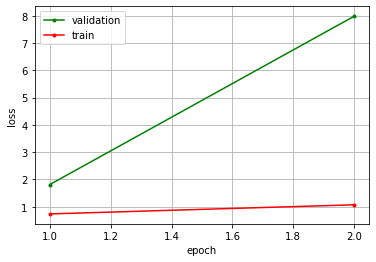

<Figure size 432x288 with 0 Axes>

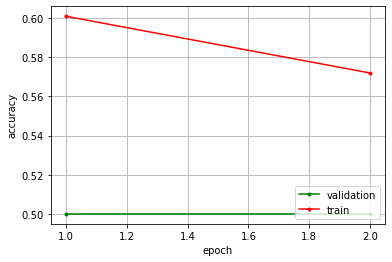

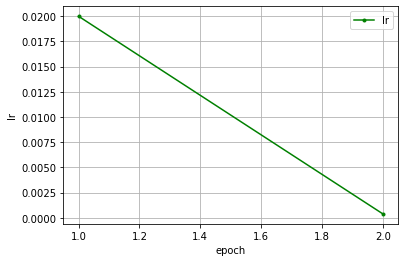

<Figure size 432x288 with 0 Axes>

In [22]:
def get_cb(output_dir:str, num_epoch:int) -> list:
    """ trainでつかうkerasのcallback取得 """
    cb = []
    # 学習率をエポック増やすごとにコサインカーブで上げ下げする. epochsはコサインカーブのほぼ半周期になるエポック数
    cb.append(my_callback.cosine_annealing(factor=lr_factor, epochs=num_epoch))
    # ログを保存するカスタムコールバック
    cb.append(my_callback.tsv_logger(os.path.join(output_dir, 'tsv_logger.tsv')))
    # epochごとに学習曲線保存する自作callback
    cb.append(my_callback.learning_curve_plot(os.path.join(output_dir, 'learning_curve.png')))
    # 各エポックでval_lossが最小となるモデル保存
    cb.append(keras.callbacks.ModelCheckpoint(filepath=os.path.join(output_dir, 'val_loss_best.h5'), monitor='val_loss', save_best_only=True, verbose=1))
    cb.append(keras.callbacks.ModelCheckpoint(filepath=os.path.join(output_dir, 'val_accuracy_best.h5'), monitor='val_accuracy', save_best_only=True, verbose=1, mode='max'))
    # 過学習の抑制 <early_stopping_pati>step続けてval_loss減らなかったら打ち切る
    cb.append(keras.callbacks.EarlyStopping(monitor='val_loss', patience=num_epoch//2, verbose=1))
    return cb

start_time = time.time()
history = model.fit_generator(
    d_cls.train_gen
    , steps_per_epoch = train_samples//batch_size
    , epochs = num_epoch
    , validation_data = d_cls.valid_gen
    , validation_steps = val_samples//val_batch_size
    , verbose = 1 # 1:ログをプログレスバーで標準出力 2:最低限の情報のみ出す
    , callbacks = get_cb(output_dir, num_epoch)
    )
end_time = time.time()
print("Elapsed Time : {:.2f}sec".format(end_time - start_time))

# lossやaccの学習履歴のグラフ保存
plot_log.plot_results(output_dir, os.path.join(output_dir, 'tsv_logger.tsv'), acc_metric=metrics[0])

#### predict

,Filename,PredictionLabel,PredictionScore
0,Cat\10024.jpg,Dog,0.986
1,Cat\10046.jpg,Dog,0.932
2,Cat\10070.jpg,Dog,0.942
3,Cat\10122.jpg,Dog,0.952
4,Cat\10136.jpg,Dog,0.956


y_pred_list_str: ['Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog'
 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog'
 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog'
 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog'
 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog'
 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog'
 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog'
 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog'
 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog'
 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog'
 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog'
 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog'
 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog'
 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Do

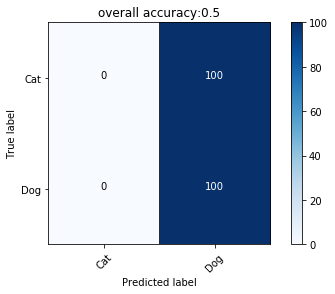

<Figure size 432x288 with 0 Axes>

In [23]:
# Custom Functionを使ったmodelを別環境で使用するには、modelをロードする際に引数として、[custom_objects]を指定するがある
# https://qiita.com/tkinjo1/items/51f9e2d0d9c4659bde8a
#load_model = keras.models.load_model(os.path.join(output_dir, 'val_loss_best.h5'), custom_objects={'lr':lr_metric})
load_model = keras.models.load_model(os.path.join(output_dir, 'val_loss_best.h5'))

# generatorで全件予測
pred_df = base_predict.pred_classes_generator(load_model, d_cls.test_gen, classes_list=class_name)
pred_df.to_csv(os.path.join(output_dir, 'pred.tsv'), sep='\t')
display(pred_df.head())

# 予測結果のデータフレームから混同行列作成
base_predict.conf_matrix_from_pred_classes_generator(pred_df, classes, output_dir)

#### Grad-CAM

In [26]:
out_grad_cam_dir = os.path.join(output_dir, 'grad_cam/test')
os.makedirs(out_grad_cam_dir, exist_ok=True)

for i,p in tqdm(enumerate(util.find_img_files(test_dir))):
                
    # 10枚ごとにモデル再ロード
    if i % 10 == 0:
        keras.backend.clear_session() # セッションのクリア
        keras.backend.set_learning_phase(0) # Test時には0にセット DropoutやBatchNormありmodelのときはロード前にこれがないとGradCamエラーになる
        model = keras.models.load_model(os.path.join(output_dir, 'val_loss_best.h5'), compile=False) # モデルロード
    
    grad_cam_img = grad_cam.image2gradcam(model, p, out_dir=out_grad_cam_dir, is_gradcam_plus=False)
    
    if i == 15:
        break

out_jpg: D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test\grad_cam/test/10024_classidx1_gradcam.jpg
out_jpg: D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test\grad_cam/test/10046_classidx1_gradcam.jpg
out_jpg: D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test\grad_cam/test/10070_classidx1_gradcam.jpg
out_jpg: D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test\grad_cam/test/10122_classidx1_gradcam.jpg
out_jpg: D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test\grad_cam/test/10136_classidx1_gradcam.jpg
out_jpg: D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test\grad_cam/test/10141_classidx1_gradcam.jpg
out_jpg: D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test\grad_cam/test/10185_classidx1_gradcam.jpg
out_jpg: D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf_Cats_VS._Dogs_test\grad_cam/test/10283_classidx1_gradcam.jpg
out_jpg: D:\work\kaggle_data\tf_Cats_VS._Dogs\results\tf

Num_Images:  16


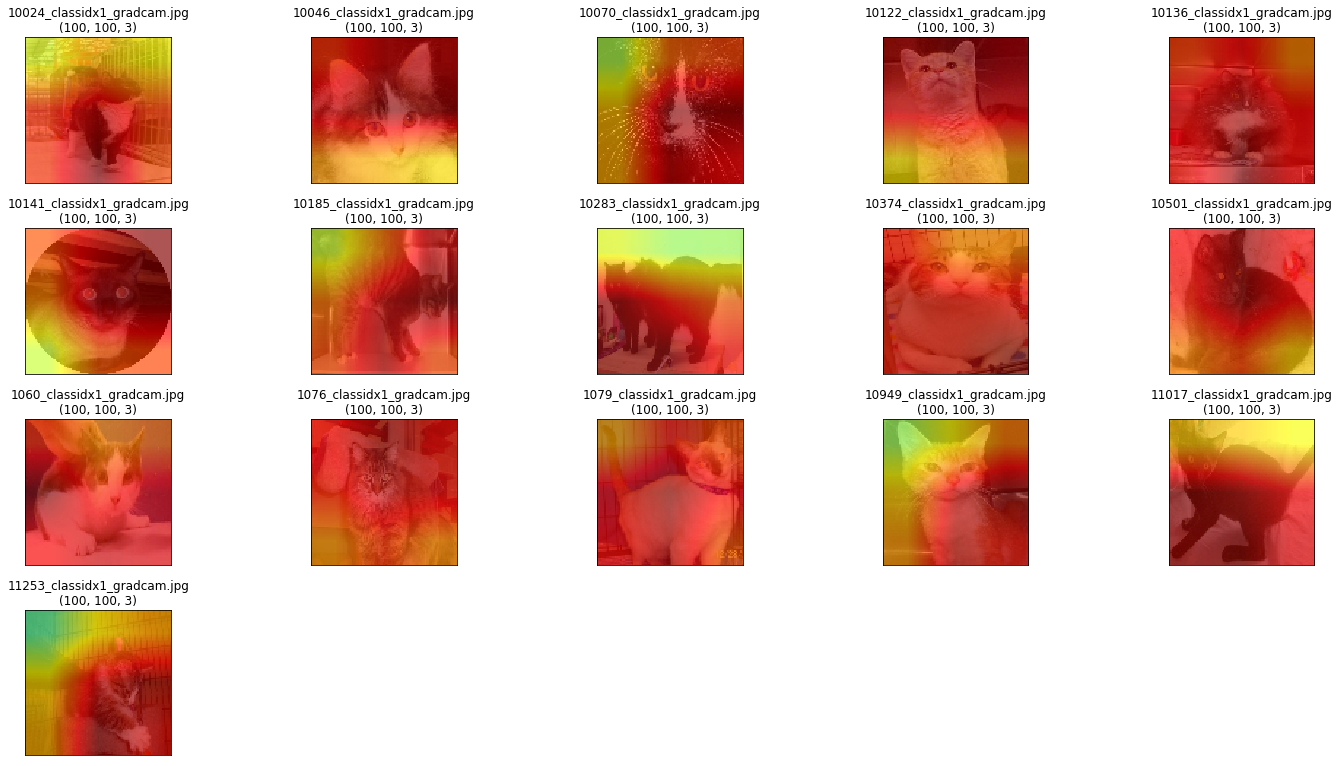

<Figure size 432x288 with 0 Axes>

In [27]:
img_list = glob.glob(out_grad_cam_dir+'/*.jpg')
num = 30
util.plot_5imgs(img_list
                , plot_num=num
                , figsize=(10*2, 8*2)
                , labels=[str(pathlib.Path(p).name) for p in img_list[:num]])

In [34]:
# import the necessary packages
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName

        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name

        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, 
                self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]

        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads

        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))

        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")

        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)

        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)
    
cam = GradCAM(model, 0)
x,y = next(d_cls.test_gen)
heatmap = cam.compute_heatmap(x[0:1])
#(heatmap, output) = cam.overlay_heatmap(heatmap, x[0]*255.0, alpha=0.5)


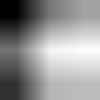

In [40]:
import cv2

jetcam = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
keras.preprocessing.image.array_to_img(jetcam)

In [39]:
heatmap

array([[  0,   0,   0, ..., 162, 162, 162],
       [  0,   0,   0, ..., 162, 162, 162],
       [  0,   0,   0, ..., 162, 162, 162],
       ...,
       [ 49,  49,  49, ..., 188, 188, 188],
       [ 49,  49,  49, ..., 188, 188, 188],
       [ 49,  49,  49, ..., 188, 188, 188]], dtype=uint8)